In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from collections import OrderedDict
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder


# from preprocessing import *

import matplotlib.pyplot as plt
# 폰트 적용
plt.rcParams['font.family'] = 'Malgun Gothic'

In [4]:
import os
print(os.getcwd())

# os.chdir("D:/Anaconda/210917_Syn_Anomaly_detection")

C:\Users\kcs\df_syn_generation_m


In [5]:
os.chdir("C:/Users/kcs/df_syn_generation_m")

## 1. Load Dataset 

In [6]:
X_train = pd.read_csv('./label_syn/encoding_train1.csv', encoding='utf-8-sig')
# X_train1 = pd.read_csv('./label_syn/encoding_train1.csv', encoding='utf-8-sig')
X_valid = pd.read_csv('./label_syn/encoding_test.csv', encoding='utf-8-sig')

In [7]:
y_train= pd.read_csv('./label_syn/y_train1.csv', encoding='utf-8-sig')
# y_train1= pd.read_csv('./label_syn/y_train1.csv', encoding='utf-8-sig')
y_valid= pd.read_csv('./label_syn/y_test.csv', encoding='utf-8-sig')

In [8]:
y_valid.value_counts()

우범여부
0       6968
1       1958
dtype: int64

In [9]:
X_train.shape

(36592, 18)

In [10]:
y_train.shape

(36592, 1)

## 1_2 Load Dataset  & Feature Importance 반영

In [11]:
X_train.columns

Index(['신고세관부호', '수입신고구분코드', '수입거래구분코드', '수입종류코드', '징수형태코드', '운송수단유형코드',
       '신고인부호', '수입자', '해외거래처부호', '특송업체부호', 'HS10단위부호', '적출국가코드', '원산지국가코드',
       '관세율', '관세율구분코드', '원산지표시유무코드', '신고중량(KG)', '과세가격원화금액'],
      dtype='object')

In [12]:
X_valid.head(5)

,신고세관부호,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,운송수단유형코드,신고인부호,수입자,해외거래처부호,특송업체부호,HS10단위부호,적출국가코드,원산지국가코드,관세율,관세율구분코드,원산지표시유무코드,신고중량(KG),과세가격원화금액
0,2,1,7,2,1,6,430,3539,1,1,1660,1,1,11,3,4,1.037901e-05,0.638408
1,14,1,3,2,1,2,448,4899,1,1,1051,11,12,4,30,5,3.844731e-04,0.639131
2,13,1,2,2,3,4,4,1499,1,1,39,1,1,8,2,3,9.995835e-04,0.643048
3,23,1,5,2,1,1,759,10151,1,1,181,11,12,1,1,2,1.665973e-07,0.638318
4,12,1,1,2,10,3,693,14725,1,1,3572,33,32,1,1,4,3.248646e-06,0.638491


In [13]:
X_train.head(5)

,신고세관부호,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,운송수단유형코드,신고인부호,수입자,해외거래처부호,특송업체부호,HS10단위부호,적출국가코드,원산지국가코드,관세율,관세율구분코드,원산지표시유무코드,신고중량(KG),과세가격원화금액
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3.331945e-08,0.638318
1,2,1,2,2,1,2,2,2,1,1,2,1,1,2,2,2,3.331945e-08,0.638318
2,3,1,3,2,2,3,3,3,1,2,3,1,1,1,1,2,3.331945e-08,0.638318
3,4,1,4,2,3,1,4,4,1,1,2,1,1,2,2,2,6.663890e-07,0.638318
4,5,1,5,2,1,3,5,5,2,1,4,1,2,3,1,1,0.000000e+00,0.638318


## 2. Over sampling

In [14]:
# !pip install imbalanced-learn
# from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

In [15]:
over_sampler = RandomOverSampler(random_state = 11)
X_train_over,y_train_over = over_sampler.fit_resample(X_train,y_train)
print('Oversampler 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('Oversampler 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('Oversampler 적용 후 레이블 값 분포: \n', y_train_over.value_counts())

Oversampler 적용 전 학습용 피처/레이블 데이터 세트:  (36592, 18) (36592, 1)
Oversampler 적용 후 학습용 피처/레이블 데이터 세트:  (57484, 18) (57484, 1)
Oversampler 적용 후 레이블 값 분포: 
 우범여부
0       28742
1       28742
dtype: int64


In [16]:
over_sampler = RandomOverSampler(random_state = 11)
X_valid_over,y_valid_over = over_sampler.fit_resample(X_valid,y_valid)
print('Oversampler 적용 전 학습용 피처/레이블 데이터 세트: ', X_valid.shape, y_train.shape)
print('Oversampler 적용 후 학습용 피처/레이블 데이터 세트: ', X_valid_over.shape, y_valid_over.shape)
print('Oversampler 적용 후 레이블 값 분포: \n', y_valid_over.value_counts())

Oversampler 적용 전 학습용 피처/레이블 데이터 세트:  (8926, 18) (36592, 1)
Oversampler 적용 후 학습용 피처/레이블 데이터 세트:  (13936, 18) (13936, 1)
Oversampler 적용 후 레이블 값 분포: 
 우범여부
0       6968
1       6968
dtype: int64


In [17]:
# !pip install xgboost

## 3. xgboost 파라미터 선정

In [18]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [19]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [20]:
# !pip install stats
from scipy import stats
from scipy.stats import randint
# from scipy.stats import uniform

In [90]:
# print('\n All results:')
# print(random_search.cv_results_)
# print('\n Best estimator:')
# print(random_search.best_estimator_)
# param_comb = 5
# print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
# print(random_search.best_score_ * 2 - 1)
# print('\n Best hyperparameters:')
# print(random_search.best_params_)
# results = pd.DataFrame(random_search.cv_results_)
# results.to_csv('./data1/xgb-random-grid-search-results-01.csv', index=False)

## 3. 모델학습

### 3.1 학습/테스트 데이터 학습(xgboost) 성능

In [21]:
from sklearn.metrics import confusion_matrix,precision_score,accuracy_score,recall_score,f1_score,roc_auc_score

def get_clf_eval2(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average ='macro')
    recall = recall_score(y_test, pred, average ='macro')
    f1 = f1_score(y_test, pred, average ='macro')
    
    print("오차행렬\n", confusion)
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}\n".format(accuracy, precision, recall, f1))
    
# 모델 학습 함수



def get_model_train_eval2(model, ftr_train = None, ftr_test = None, tgt_train = None, tgt_test = None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval2(tgt_test, pred, pred_proba)

In [22]:
xgb_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5994130001745845, max_delta_step=0, max_depth=4,
              min_child_weight=2, monotone_constraints='()',
              n_estimators=424, n_jobs=20, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None, objective= 'binary:logistic', eval_metric='logloss')

In [23]:
start_time = timer(None) 
get_model_train_eval2(xgb_model, ftr_train = X_train_over, ftr_test = X_valid_over, 
                      tgt_train = y_train_over, tgt_test = y_valid_over)
timer(start_time) 

오차행렬
 [[5767 1201]
 [3619 3349]]
정확도: 0.6541, 정밀도: 0.6752, 재현율: 0.6541, F1:0.6434


 Time taken: 0 hours 0 minutes and 2.24 seconds.


## 5. 모델 저장

In [24]:
# import pickle
# file_name = "./model/xgb_reg.pkl"

# # save
# pickle.dump(xgb_model, open(file_name, "wb"))

# # load
# new_xgb_model = pickle.load(open(file_name, "rb"))

### 3.2 기존 학습(xgboost) 모델을 가져와서 검증

In [25]:
from sklearn.metrics import confusion_matrix,precision_score,accuracy_score,recall_score,f1_score,roc_auc_score

def get_clf_eval2(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average ='macro')
    recall = recall_score(y_test, pred, average ='macro')
    f1 = f1_score(y_test, pred, average ='macro')
    
    print("오차행렬\n", confusion)
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}\n".format(accuracy, precision, recall, f1))
    
# 모델 학습 함수
def get_model_train_eval2(model, ftr_train = None, ftr_test = None, tgt_train = None, tgt_test = None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval2(tgt_test, pred, pred_proba)

In [26]:
# 모델 불러오기

file_name = "./model/xgb_reg.pkl"

# load
w_xgb_model = pickle.load(open(file_name, "rb"))

In [27]:
# predict, predict_proba 추출

w_preds = w_xgb_model.predict(X_valid_over)
w_pred_proba = w_xgb_model.predict_proba(X_valid_over)[:,1]

In [28]:
# get_clf_eval()를 이용해 사키릿런 래퍼 XGBoost로 만들어진 모델 예측 성능 평가

get_clf_eval2(y_valid_over, w_preds, w_pred_proba)

오차행렬
 [[5767 1201]
 [3619 3349]]
정확도: 0.6541, 정밀도: 0.6752, 재현율: 0.6541, F1:0.6434



## 4. Feature Importance (사이킷 런 xgboost)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

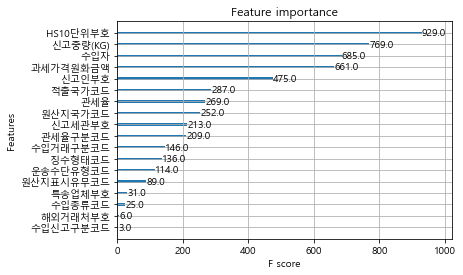

In [29]:
%matplotlib inline
from xgboost import plot_importance

plot_importance(xgb_model, max_num_features=20)

In [30]:
import eli5 
from eli5.sklearn import PermutationImportance 
perm = PermutationImportance(xgb_model, scoring = "accuracy", random_state = 22).fit(X_valid_over, y_valid_over) 
eli5.show_weights(perm, top = 20, feature_names = X_valid_over.columns.tolist())

Weight,Feature
0.0653 ± 0.0052,신고중량(KG)
0.0641 ± 0.0070,HS10단위부호
0.0528 ± 0.0019,과세가격원화금액
0.0273 ± 0.0013,관세율
0.0248 ± 0.0033,적출국가코드
0.0184 ± 0.0023,원산지국가코드
0.0136 ± 0.0049,관세율구분코드
0.0011 ± 0.0025,징수형태코드
0.0006 ± 0.0009,해외거래처부호
0.0001 ± 0.0009,수입종류코드


## 6. 실제 /예측값 비교

In [31]:
X_org = pd.read_csv('./label_syn/df_enc_test.csv', encoding='utf-8-sig')

In [32]:
y_valid

,우범여부
0,1
1,0
2,0
3,1
4,0
...,...
8921,1
8922,0
8923,0
8924,0


In [33]:
X_valid

,신고세관부호,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,운송수단유형코드,신고인부호,수입자,해외거래처부호,특송업체부호,HS10단위부호,적출국가코드,원산지국가코드,관세율,관세율구분코드,원산지표시유무코드,신고중량(KG),과세가격원화금액
0,2,1,7,2,1,6,430,3539,1,1,1660,1,1,11,3,4,1.037901e-05,0.638408
1,14,1,3,2,1,2,448,4899,1,1,1051,11,12,4,30,5,3.844731e-04,0.639131
2,13,1,2,2,3,4,4,1499,1,1,39,1,1,8,2,3,9.995835e-04,0.643048
3,23,1,5,2,1,1,759,10151,1,1,181,11,12,1,1,2,1.665973e-07,0.638318
4,12,1,1,2,10,3,693,14725,1,1,3572,33,32,1,1,4,3.248646e-06,0.638491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8921,12,1,5,2,1,4,363,3640,1,2,108,10,11,4,6,1,2.132445e-06,0.638325
8922,27,1,5,2,1,6,219,11506,1,1,133,8,1,1,1,1,6.663890e-08,0.638318
8923,13,1,5,2,1,2,1010,4178,1,2,409,5,9,4,8,1,1.665973e-08,0.638319
8924,3,1,2,2,1,1,229,10067,1,1,419,1,1,6,3,1,2.274052e-05,0.638345


In [34]:
pred_critical = w_xgb_model.predict(X_valid)

In [35]:
a = np.array([pred_critical])
pred_df = pd.DataFrame({'우범여부_예측':a[0]})
pred_df

,우범여부_예측
0,1
1,0
2,0
3,0
4,0
...,...
8921,1
8922,1
8923,0
8924,1


In [36]:
sample=X_org[['신고세관부호','신고인부호','수입자','HS10단위부호','우범여부']]

In [37]:
dfa = pd.DataFrame(sample)
final_df = dfa.join(pred_df)
final_df

,신고세관부호,신고인부호,수입자,HS10단위부호,우범여부,우범여부_예측
0,29,575N8BW,PEJWA0Y,8481201000,1,1
1,21,8ZM6GUW,9DIRDSY,4407299000,0,0
2,39,1XCM1XF,SRCDUMH,710807000,0,0
3,15,KEGR4JZ,XSK62NY,4202999000,1,0
4,30,607KRHF,DRMMKS4,8711301000,0,0
...,...,...,...,...,...,...
8921,30,QM7LO7M,LKVEEMK,8518109090,1,1
8922,12,DO8IOFX,RALHUGK,7326909000,0,1
8923,39,9O034UC,ML9KFEZ,8517629000,0,0
8924,40,FXK30O6,YIIADKE,9503003919,0,1


In [39]:
# 파일 저장 #
final_df.to_csv('./label_syn/predict_evaluation_test.csv', index=None, encoding='949')